In [2]:

import os
import sys
import subprocess
# sys.path.insert(1, f"{subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')}/logistics/tools")
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools
import numpy as np
import openmc
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
# from tools import image_to_thesis
# image_to_thesis.pull_from_thesis()


100%|██████████| 20/20 [00:00<00:00, 352.45it/s]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

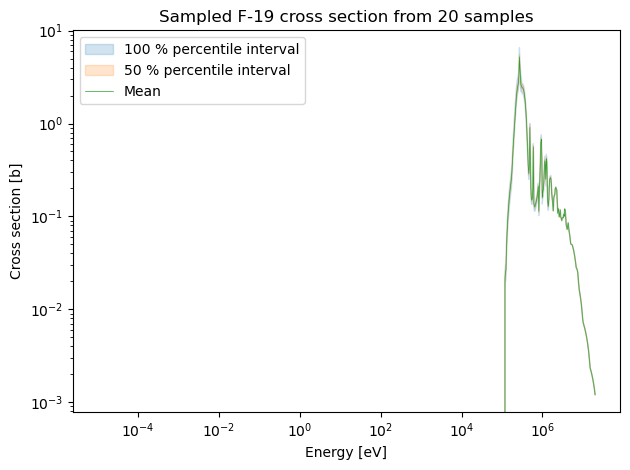

In [30]:
# VERSION = "v1"
VERSION = "v2_SINGLE_MT"

# REACTION = "002" # elastic scattering
# REACTION = "102" # radiative capture
# REACTION = "103" # nc 
# REACTION = "016" # 2n 
# REACTION = "052" # 2n 
# REACTION = "051" # heating 


for REACTION in ["002", "102", "103", "016", "052", "051"]:
    plt.clf()
    plt.figure()

    if VERSION == "v1":
        sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v1/hdf5/F19"
    elif VERSION == "v2":
        sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v2"
    elif VERSION == "v2_SINGLE_MT":
        sampled_h5_files_path = "/home/fne23_stjarnholm/nuclear_data/sandy_samples_v2_TEST_SINGLE_MT"

    fig = plt.figure()
    ax = fig.gca()

    TEMPERATURE = 900 # K

    x_logspace = np.logspace(np.log10(1e-5), np.log10(2e7), 1000)

    df = pd.DataFrame(columns=["energy", "xs"])

    N_ITERATIONS = 20
    for i in tqdm(range(N_ITERATIONS)):
        h5_filename = f"{sampled_h5_files_path}/F19-{i+1}.h5"

        h5file = h5py.File(h5_filename, 'r')
        energy_group = h5file[f'F19/energy/{TEMPERATURE}K']
        reactions_group = h5file[f'F19/reactions']
        # for name, obj in sorted(list(main_group.items()))[:10]:
        #     if 'reaction_' in name:
        #         print('{}, {}'.format(name, obj.attrs['label'].decode()))

        n_elastic_xs_group = reactions_group[f'reaction_{REACTION}/{TEMPERATURE}K/xs']
        # print(list(n_elastic_group.values()))

        # Extract the cross section and energy data
        xs = n_elastic_xs_group[:]
        if len(xs) != len(energy_group[:]):
            energy = energy_group[-len(xs):]
        else:
            energy = energy_group[:]
        

        # print(energy.shape)
        # print(xs.shape)

        # Interpolate the cross section to the desired energy grid
        xs = np.interp(x_logspace, energy, xs)
        energy = x_logspace

        df = pd.concat([df, pd.DataFrame({"energy": energy, "xs": xs})], ignore_index=True)

        # F19_reconstructed = openmc.data.IncidentNeutron.from_hdf5(h5_filename)

        # Plot the sampled cross section
        # ax.loglog(energy, xs, label="Sampled")
        ax.loglog(energy, xs, label="Sampled", color="darkgrey", linewidth=0.1)

    ax.set_xlabel("Energy [eV]")
    ax.set_ylabel("Cross section [b]")
    ax.set_title(f"Sampled F-19 cross section from {N_ITERATIONS} samples")

    plt.savefig(f"sampled_cross_section_plot_{VERSION}_{REACTION}.png", dpi=300)
        
    plt.clf()
    plt.figure()
    ax = plt.gca()

    sns.lineplot(data=df, x="energy", y="xs", errorbar=('pi', 100), linewidth=0, label='_nolegend_')
    sns.lineplot(data=df, x="energy", y="xs", errorbar=('pi', 50), linewidth=0, label="_nolegend_")
    sns.lineplot(data=df, x="energy", y="xs", errorbar=None, linewidth=0.5, label="")
    plt.xscale("log")
    plt.yscale("log")

    ax.set_xlabel("Energy [eV]")
    ax.set_ylabel("Cross section [b]")
    ax.set_title(f"Sampled F-19 cross section from {N_ITERATIONS} samples")
    # plt.legend(['Mean', '50 % percentile interval', '90 % percentile interval', '100 % percentile interval'])
    plt.legend(['100 % percentile interval', '50 % percentile interval', 'Mean'])
    plt.tight_layout()

    plt.savefig(f"errorbands_sampled_cross_section_plot_{VERSION}_{REACTION}.pdf")

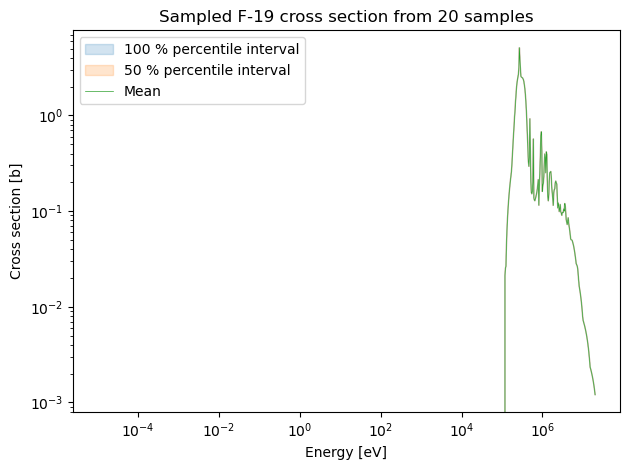